In [267]:
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt

from ReadMaestro import maestro
from ReadMaestro import parse_pursuit_trials
paths = [p for p in sys.path if os.path.exists(p)]
print(paths)

from importlib import reload
reload(maestro)
reload(parse_pursuit_trials)

['/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '/home/seth/.local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages']


<module 'ReadMaestro.parse_pursuit_trials' from '/home/seth/analysis/ReadMaestro/ReadMaestro/parse_pursuit_trials.py'>

In [2]:
#file_path = '/home/seth/Projects/DynamicCoherencePhysiology/ar/20220404a/ar220404a.0001'
#with open(file_path, 'rb') as f:
#    data_file = maestro.DataFile.load(f.read(), file_path)

In [76]:
data = maestro.load_directory('/home/seth/Projects/DynamicCoherencePhysiology/ar/20220404a')

In [274]:
purs = parse_pursuit_trials.pursuitDataObject
purs.__init__(purs)
purs.setName(purs,data)
print(purs.name)

purs.pursuitData(purs,data,trialIDs=['initCoh'], directions=[0.0,45.0,90.0,135.0,180.0,225.0,270.0,315.0], speeds=[10.0], coherences=[], perturbations=[]);
purs.applyRotationToData(purs)
purs.setSaccadeVelocitiesToNaN(purs)

/home/seth/Projects/DynamicCoherencePhysiology/ar/2022040


Text(0, 0.5, 'Horizontal velocity (deg/s)')

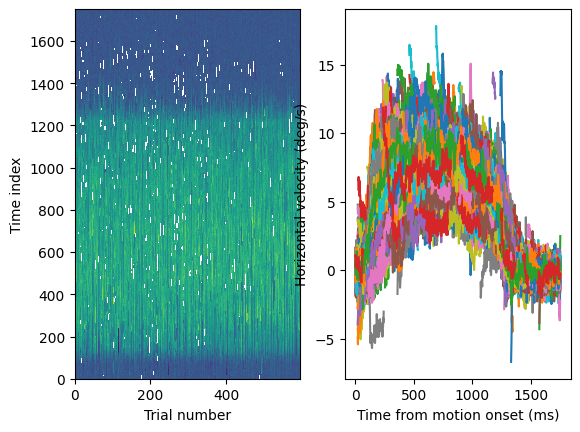

In [275]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].pcolor(purs.hvelocities);
axes[0].set_xlabel('Trial number')
axes[0].set_ylabel('Time index')
axes[1].plot(purs.eye_t,purs.hvelocities);
axes[1].set_xlabel('Time from motion onset (ms)')
axes[1].set_ylabel('Horizontal velocity (deg/s)')

In [270]:
mu, C = purs.computeMeanCov(purs.hvelocities)

print(np.shape(C))
print(np.shape(mu))

(1751, 1751)
(1751,)


Text(0, 0.5, 'Mean horizontal velocity (deg/s)')

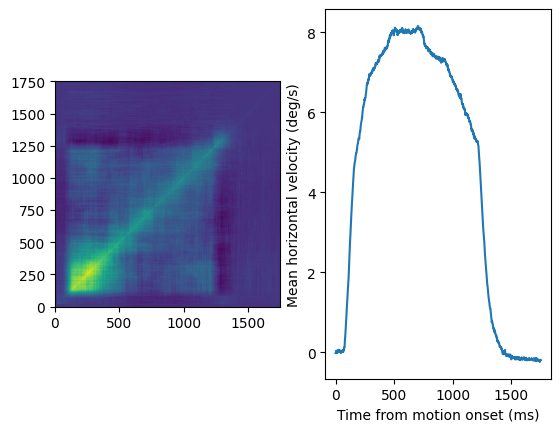

In [271]:

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].pcolor(C);
axes[0].set_aspect('equal', 'box')
axes[1].plot(purs.eye_t,mu)
axes[1].set_xlabel('Time from motion onset (ms)')
axes[1].set_ylabel('Mean horizontal velocity (deg/s)')